# Mechanics of forecasting

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/209-mechanics-of-forecasting.ipynb)

This notebook uncovers the details of forecasting by pipelines in ETNA library. We are going to explain how pipelines are dealing with dataset, transforms and models to make a prediction.

**Table of contents**

* [Loading dataset](#chapter1)
* [Forecasting](#chapter2)
    * [Context-free models](#section_2_1)
    * [Context-required models](#section_2_2)
    * [ML models](#section_2_3)
* [Summary](#chapter3)

In [1]:
!pip install "etna[prophet]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

from etna.datasets import TSDataset

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [4]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


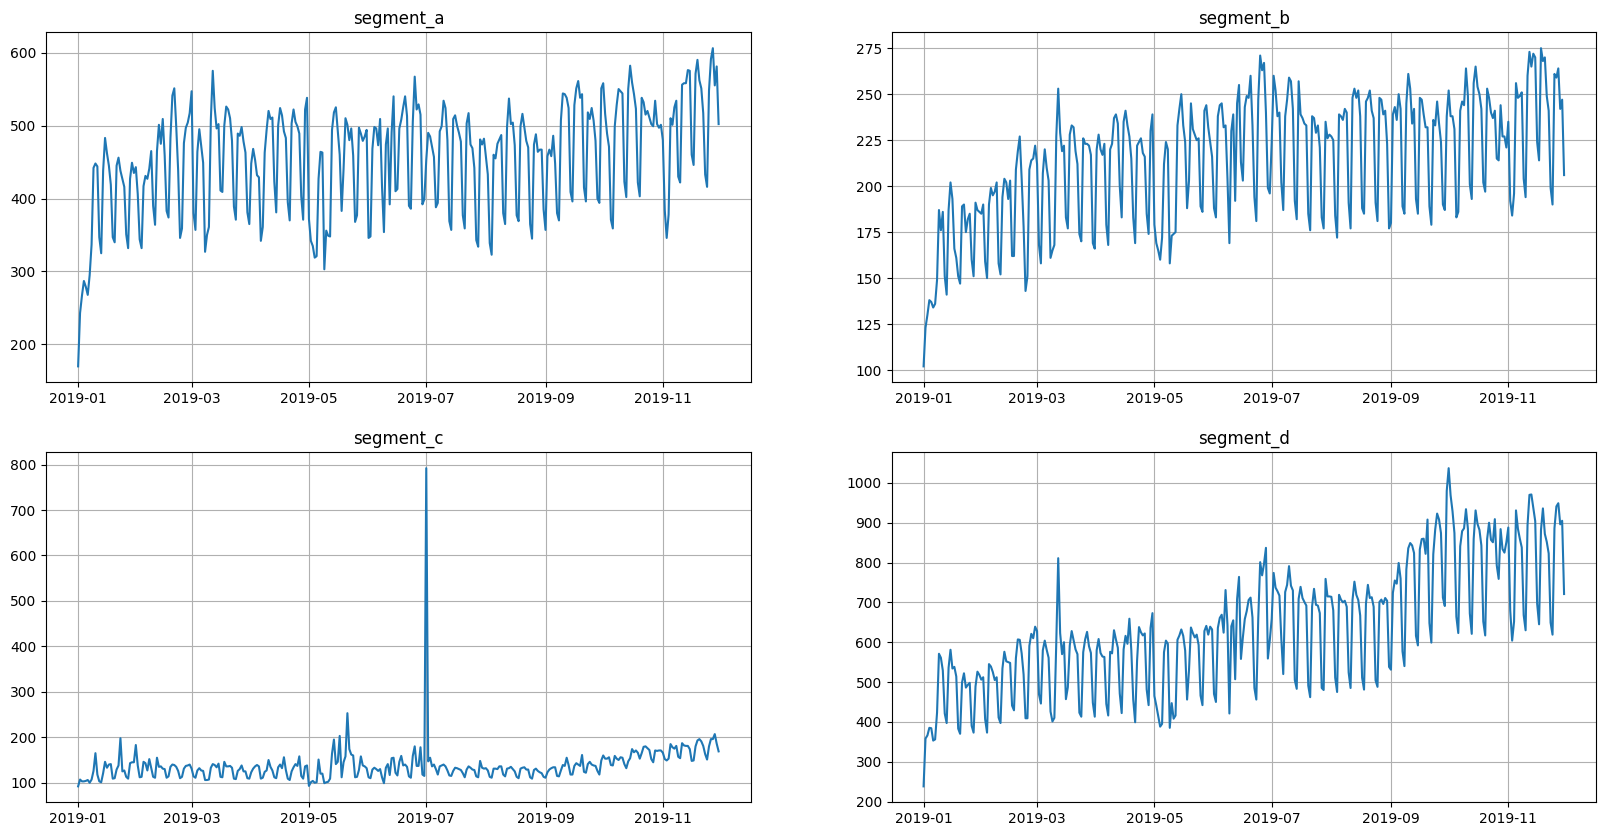

In [5]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

## 2. Forecasting <a class="anchor" id="chapter2"></a>

Now let's dive deeper into forecasting without pipelines. We are going to use only `TSDataset`, transforms and models.

In [6]:
HORIZON = 14

In [7]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [8]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-17    2019-11-30      14            0
segment_b      2019-11-17    2019-11-30      14            0
segment_c      2019-11-17    2019-11-30      14            0
segment_d      2019-11-17    2019-11-30      14            0


### 3.1 Context-free models <a class="anchor" id="section_2_1"></a>

Let's start by using the `ProphetModel`, because it doesn't require any transformations and doesn't need any context.

Fitting the model is very easy

In [9]:
from etna.models import ProphetModel

model = ProphetModel()
model.fit(train_ts)

11:01:25 - cmdstanpy - INFO - Chain [1] start processing
11:01:25 - cmdstanpy - INFO - Chain [1] done processing
11:01:25 - cmdstanpy - INFO - Chain [1] start processing
11:01:25 - cmdstanpy - INFO - Chain [1] done processing
11:01:25 - cmdstanpy - INFO - Chain [1] start processing
11:01:25 - cmdstanpy - INFO - Chain [1] done processing
11:01:25 - cmdstanpy - INFO - Chain [1] start processing
11:01:25 - cmdstanpy - INFO - Chain [1] done processing


ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'additive', seasonality_prior_scale = 10.0, holidays_prior_scale = 10.0, changepoint_prior_scale = 0.05, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), )

To make a forecast we should create a dataset with future data by using `make_future` method. We are currently interested in only `future_steps` parameter, it determines how many timestamps should be created after the end of the history.

As a result we would have a dataset with `future_steps` timestamps.

In [10]:
future_ts = train_ts.make_future(future_steps=HORIZON)
future_ts

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-17,NaN,NaN,NaN,NaN
2019-11-18,NaN,NaN,NaN,NaN
2019-11-19,NaN,NaN,NaN,NaN
2019-11-20,NaN,NaN,NaN,NaN
2019-11-21,NaN,NaN,NaN,NaN
2019-11-22,NaN,NaN,NaN,NaN
2019-11-23,NaN,NaN,NaN,NaN
2019-11-24,NaN,NaN,NaN,NaN


Now we are ready to make a forecast

In [11]:
forecast_ts = model.forecast(future_ts)
forecast_ts

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-17,415.300214,196.610084,143.769761,723.287233
2019-11-18,528.270723,248.186730,181.336869,900.630429
2019-11-19,544.854787,253.049163,173.502291,938.072558
2019-11-20,535.458739,248.527842,169.407795,921.954696
2019-11-21,528.720640,244.837321,169.601296,916.216922
2019-11-22,516.531192,240.322263,168.009967,906.355884
2019-11-23,429.297574,203.910951,147.698344,759.476794
2019-11-24,417.935844,197.126646,146.009019,735.950357


We should note that `forecast_ts` isn't a new dataset, it is the same object as `future_ts`, but filled with predicted values

In [12]:
forecast_ts is future_ts

True

Now let's look at a metric and plot the prediction.

In [13]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 6.179808820305944,
 'segment_c': 9.107343268713644,
 'segment_d': 6.197016763401841,
 'segment_b': 4.162295213860478}

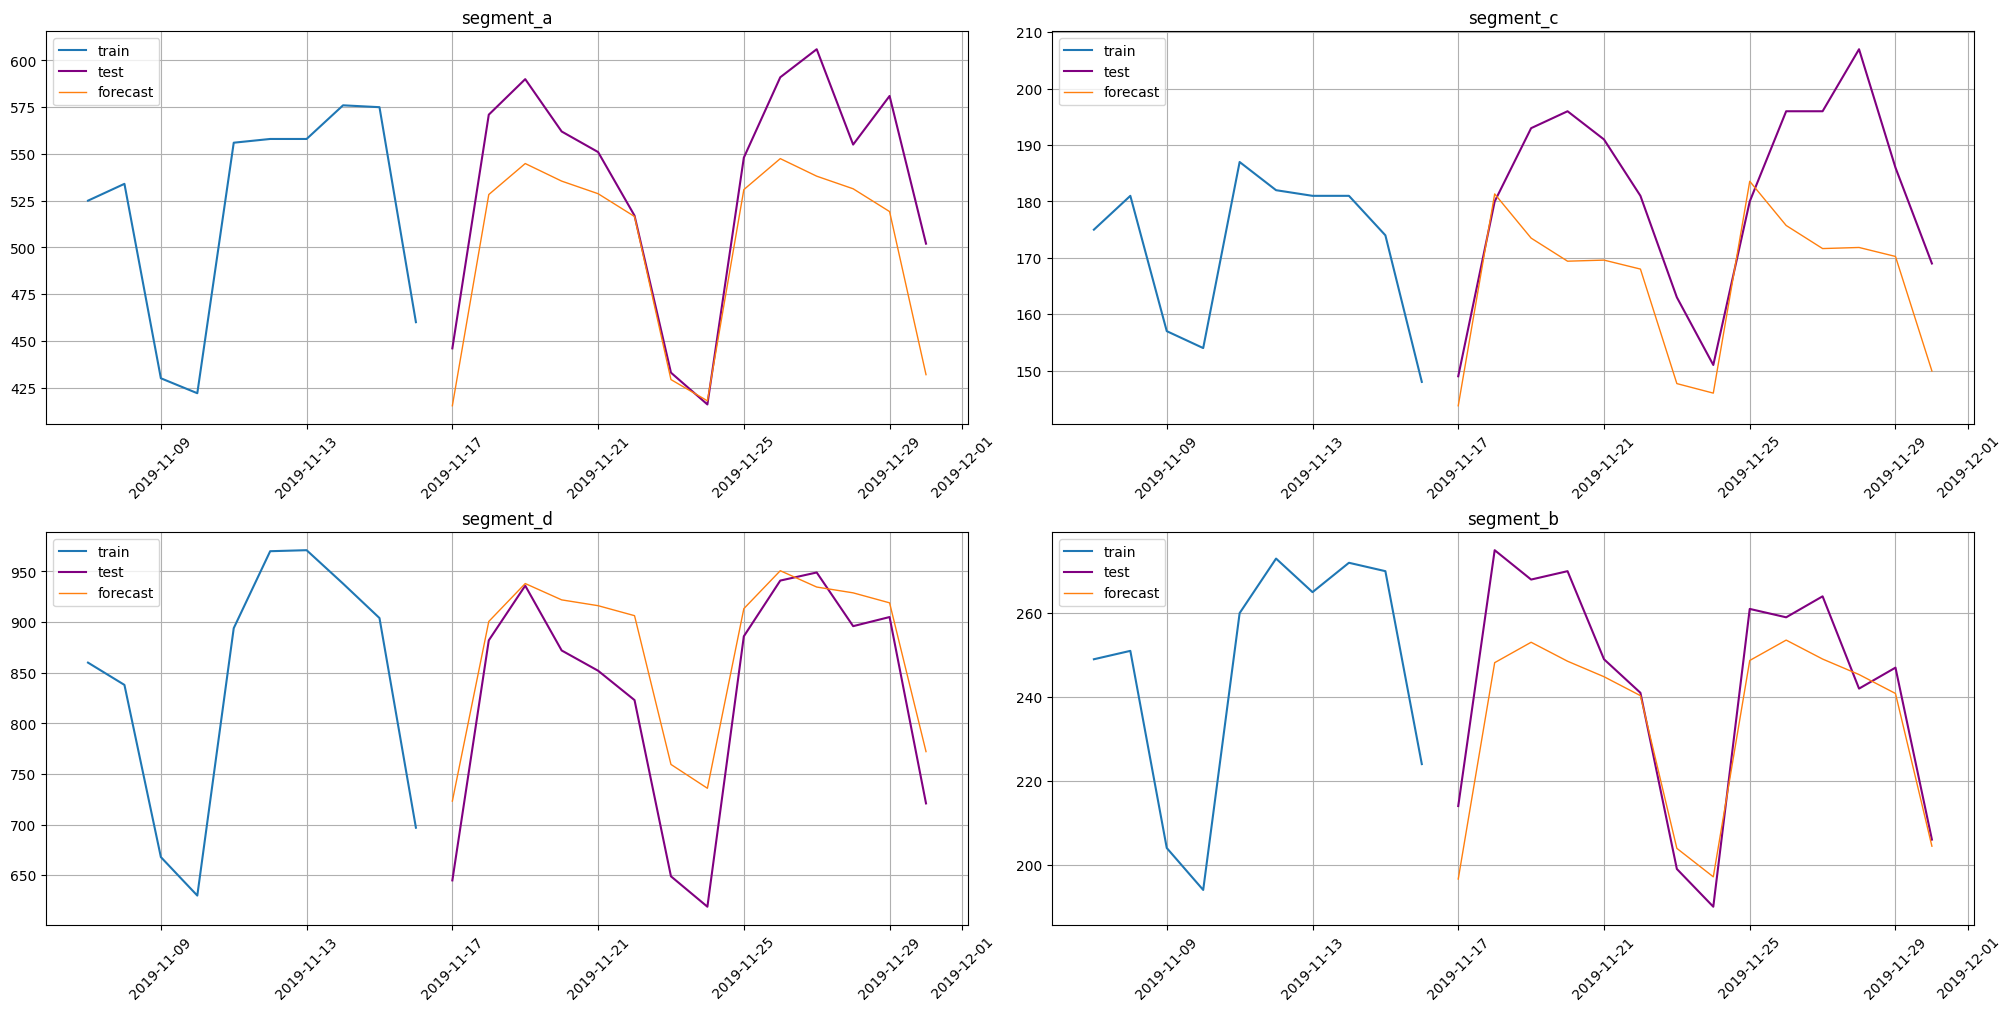

In [14]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.2 Context-required models <a class="anchor" id="section_2_2"></a>

First of all, let's clarify that context is. The context is a history data the precedes the forecasting horizon.

And now let's expand our scheme to models that require some history context for forecasting. The example is `NaiveModel`, because it needs to know the value `lag` steps ago.

The fitting doesn't change

In [15]:
from etna.models import NaiveModel

model = NaiveModel(lag=14)
model.fit(train_ts)

NaiveModel(lag = 14, )

The models has `context_size` attribute that in this particular case is equal to `lag`

In [16]:
model.context_size

14

Future generation now needs a new parameter: `tail_steps`, it determines how many timestamps should be created before the end of the history.

The result will contain `future_steps + tail_step` timestamps.

In [17]:
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
future_ts

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-03,346.0,184.0,149.0,604.0
2019-11-04,378.0,196.0,153.0,652.0
2019-11-05,510.0,256.0,185.0,931.0
2019-11-06,501.0,248.0,178.0,885.0
2019-11-07,525.0,249.0,175.0,860.0
2019-11-08,534.0,251.0,181.0,838.0
2019-11-09,430.0,204.0,157.0,668.0
2019-11-10,422.0,194.0,154.0,630.0


Forecasting is slightly changed too. We need to pass `prediction_size` parameter that determines how many timestamps we want to see in our result.

In [18]:
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)
forecast_ts

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-11-17,346.0,184.0,149.0,604.0
2019-11-18,378.0,196.0,153.0,652.0
2019-11-19,510.0,256.0,185.0,931.0
2019-11-20,501.0,248.0,178.0,885.0
2019-11-21,525.0,249.0,175.0,860.0
2019-11-22,534.0,251.0,181.0,838.0
2019-11-23,430.0,204.0,157.0,668.0
2019-11-24,422.0,194.0,154.0,630.0


The `forecast_ts` and `future_ts` are still the same object

In [19]:
forecast_ts is future_ts

True

The result of forecasting

In [20]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 9.362036158596007,
 'segment_c': 6.930906591160424,
 'segment_d': 4.304033333591803,
 'segment_b': 7.520927594702097}

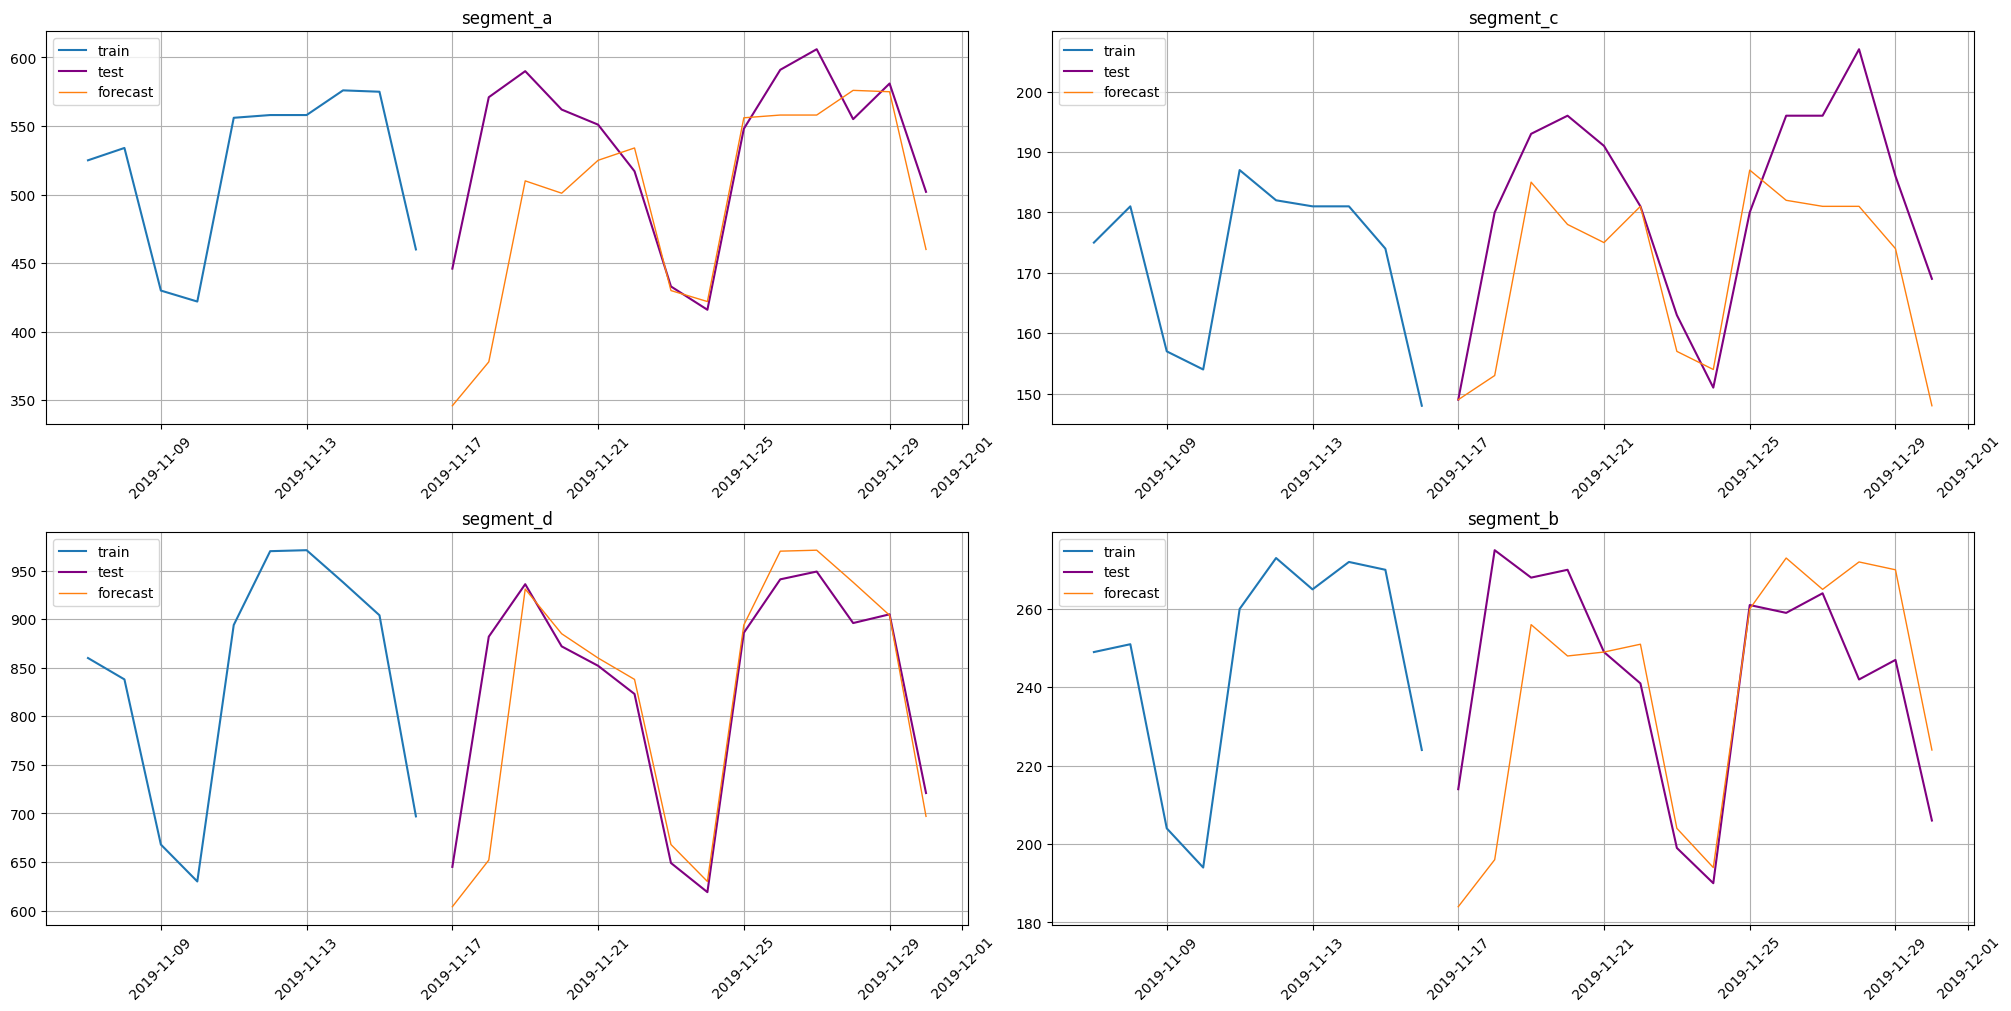

In [21]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.3 ML models <a class="anchor" id="section_2_3"></a>

Now we are going to expand our scheme even further by using transformations.

Let's define the transformations

In [22]:
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LogTransform
from etna.transforms import SegmentEncoderTransform

log = LogTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 3)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    week_number_in_month=False,
    is_weekend=False,
    out_column="date_flag",
)
transforms = [log, lags, date_flags, seg]

Fitting the models requires the transformations to be applied to the dataset

In [23]:
train_ts

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384
...,...,...,...,...
2019-11-12,558,273,182,970
2019-11-13,558,265,181,971


In [24]:
train_ts.fit_transform(transforms)
train_ts

segment                       segment_a                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-01-01                            1       NaN       NaN       NaN   
2019-01-02                            2       NaN       NaN       NaN   
2019-01-03                            3       NaN       NaN       NaN   
2019-01-04                            4       NaN       NaN       NaN   
2019-01-05                            5       NaN       NaN       NaN   
...                                 ...       ...       ...       ...   
2019-11-12                            1  2.701568  2.728354  2.698970   
2019-11-13                            2  2.697229  2.701568  2.728354   
2019-11-14                            3  2.700704  2.697229  2.701568   
2019-11-15                            4  2.682145  2.700704  2.697229   
2019-11-16                            5  2.585461  2.682145  2.700704   

segment                                              segment_b            \
feature    segment_code    target date_flag_day_number_in_week    lag_14   
timestamp                                                                  
2019-01-01            0  2.232996                            1       NaN   
2019-01-02            0  2.387390                            2       NaN   
2019-01-03            0  2.428135                            3       NaN   
2019-01-04            0  2.459392                            4       NaN   
2019-01-05            0  2.447158                            5       NaN   
...                 ...       ...                          ...       ...   
2019-11-12            0  2.747412                            1  2.357935   
2019-11-13            0  2.747412                            2  2.357935   
2019-11-14            0  2.761176                            3  2.346353   
2019-11-15            0  2.760422                            4  2.372912   
2019-11-16            0  2.663701                            5  2.285557   

segment                         ... segment_c                         \
feature       lag_15    lag_16  ...    lag_15    lag_16 segment_code   
timestamp                       ...                                    
2019-01-01       NaN       NaN  ...       NaN       NaN            2   
2019-01-02       NaN       NaN  ...       NaN       NaN            2   
2019-01-03       NaN       NaN  ...       NaN       NaN            2   
2019-01-04       NaN       NaN  ...       NaN       NaN            2   
2019-01-05       NaN       NaN  ...       NaN       NaN            2   
...              ...       ...  ...       ...       ...          ...   
2019-11-12  2.389166  2.332438  ...  2.235528  2.164353            2   
2019-11-13  2.357935  2.389166  ...  2.232996  2.235528            2   
2019-11-14  2.357935  2.357935  ...  2.235528  2.232996            2   
2019-11-15  2.346353  2.357935  ...  2.235528  2.235528            2   
2019-11-16  2.372912  2.346353  ...  2.222716  2.235528            2   

segment                                 segment_d                      \
feature       target date_flag_day_number_in_week    lag_14    lag_15   
timestamp                                                               
2019-01-01  1.968483                            1       NaN       NaN   
2019-01-02  2.033424                            2       NaN       NaN   
2019-01-03  2.017033                            3       NaN       NaN   
2019-01-04  2.017033                            4       NaN       NaN   
2019-01-05  2.021189                            5       NaN       NaN   
...              ...                          ...       ...       ...   
2019-11-12  2.262451                            1  2.921686  2.946943   
2019-11-13  2.260071                            2  2.916980  2.921686   
2019-11-14  2.260071                            3  2.930440  2.916980   
2019-11-15  2.243038       

As you can see, there are several changes made by the transforms:

- Added `date_flag_day_number_in_week` column;
- Added `lag_14`, ..., `lag_19` columns;
- Added `segment_code` column;
- Logarithm applied to `target` column.

Now we are ready to fit our model

In [25]:
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)

CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, )

In this case preparing future doesn't require dealing with the context, all the necessary information is in the features. But we have to deal with transformations by passing them into `make_future` method.

In [26]:
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)

Making a forecast

In [27]:
forecast_ts = model.forecast(future_ts)
forecast_ts

segment                       segment_a                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-11-17                            6  2.540329  2.585461  2.682145   
2019-11-18                            0  2.578639  2.540329  2.585461   
2019-11-19                            1  2.708421  2.578639  2.540329   
2019-11-20                            2  2.700704  2.708421  2.578639   
2019-11-21                            3  2.720986  2.700704  2.708421   
2019-11-22                            4  2.728354  2.720986  2.700704   
2019-11-23                            5  2.634477  2.728354  2.720986   
2019-11-24                            6  2.626340  2.634477  2.728354   
2019-11-25                            0  2.745855  2.626340  2.634477   
2019-11-26                            1  2.747412  2.745855  2.626340   
2019-11-27                            2  2.747412  2.747412  2.745855   
2019-11-28                            3  2.761176  2.747412  2.747412   
2019-11-29                            4  2.760422  2.761176  2.747412   
2019-11-30                            5  2.663701  2.760422  2.761176   

segment                                              segment_b            \
feature    segment_code    target date_flag_day_number_in_week    lag_14   
timestamp                                                                  
2019-11-17            0  2.554696                            6  2.267172   
2019-11-18            0  2.644735                            0  2.294466   
2019-11-19            0  2.688596                            1  2.409933   
2019-11-20            0  2.685920                            2  2.396199   
2019-11-21            0  2.691248                            3  2.397940   
2019-11-22            0  2.688338                            4  2.401401   
2019-11-23            0  2.628840                            5  2.311754   
2019-11-24            0  2.615757                            6  2.290035   
2019-11-25            0  2.703159                            0  2.416641   
2019-11-26            0  2.712927                            1  2.437751   
2019-11-27            0  2.719205                            2  2.424882   
2019-11-28            0  2.738940                            3  2.436163   
2019-11-29            0  2.732807                            4  2.432969   
2019-11-30            0  2.661203                            5  2.352183   

segment                         ... segment_c                         \
feature       lag_15    lag_16  ...    lag_15    lag_16 segment_code   
timestamp                       ...                                    
2019-11-17  2.285557  2.372912  ...  2.184691  2.222716            2   
2019-11-18  2.267172  2.285557  ...  2.176091  2.184691            2   
2019-11-19  2.294466  2.267172  ...  2.187521  2.176091            2   
2019-11-20  2.409933  2.294466  ...  2.269513  2.187521            2   
2019-11-21  2.396199  2.409933  ...  2.252853  2.269513            2   
2019-11-22  2.397940  2.396199  ...  2.245513  2.252853            2   
2019-11-23  2.401401  2.397940  ...  2.260071  2.245513            2   
2019-11-24  2.311754  2.401401  ...  2.198657  2.260071            2   
2019-11-25  2.290035  2.311754  ...  2.190332  2.198657            2   
2019-11-26  2.416641  2.290035  ...  2.274158  2.190332            2   
2019-11-27  2.437751  2.416641  ...  2.262451  2.274158            2   
2019-11-28  2.424882  2.437751  ...  2.260071  2.262451            2   
2019-11-29  2.436163  2.424882  ...  2.260071  2.260071            2   
2019-11-30  2.432969  2.436163  ...  2.243038  2.260071            2   

segment                                 segment_d                      \
feature       target date_flag_day_number_in_week    lag_14    lag_15   
timestamp                                                               
2019-11-17  2.174978 

The forecasted values are too small because we forecasted the target after the logarithm transformation. To get the predictions in original domain we should apply inverse transformation to the predicted values.

In [28]:
forecast_ts.inverse_transform(transforms)
forecast_ts

segment                       segment_a                                \
feature    date_flag_day_number_in_week    lag_14    lag_15    lag_16   
timestamp                                                               
2019-11-17                            6  2.540329  2.585461  2.682145   
2019-11-18                            0  2.578639  2.540329  2.585461   
2019-11-19                            1  2.708421  2.578639  2.540329   
2019-11-20                            2  2.700704  2.708421  2.578639   
2019-11-21                            3  2.720986  2.700704  2.708421   
2019-11-22                            4  2.728354  2.720986  2.700704   
2019-11-23                            5  2.634477  2.728354  2.720986   
2019-11-24                            6  2.626340  2.634477  2.728354   
2019-11-25                            0  2.745855  2.626340  2.634477   
2019-11-26                            1  2.747412  2.745855  2.626340   
2019-11-27                            2  2.747412  2.747412  2.745855   
2019-11-28                            3  2.761176  2.747412  2.747412   
2019-11-29                            4  2.760422  2.761176  2.747412   
2019-11-30                            5  2.663701  2.760422  2.761176   

segment                                                segment_b            \
feature    segment_code      target date_flag_day_number_in_week    lag_14   
timestamp                                                                    
2019-11-17            0  357.670821                            6  2.267172   
2019-11-18            0  440.301186                            0  2.294466   
2019-11-19            0  487.197559                            1  2.409933   
2019-11-20            0  484.198921                            2  2.396199   
2019-11-21            0  490.187832                            3  2.397940   
2019-11-22            0  486.908139                            4  2.401401   
2019-11-23            0  424.441403                            5  2.311754   
2019-11-24            0  411.816246                            6  2.290035   
2019-11-25            0  503.846045                            0  2.416641   
2019-11-26            0  515.329473                            1  2.437751   
2019-11-27            0  522.847495                            2  2.424882   
2019-11-28            0  547.201141                            3  2.436163   
2019-11-29            0  539.514121                            4  2.432969   
2019-11-30            0  457.356159                            5  2.352183   

segment                         ... segment_c                         \
feature       lag_15    lag_16  ...    lag_15    lag_16 segment_code   
timestamp                       ...                                    
2019-11-17  2.285557  2.372912  ...  2.184691  2.222716            2   
2019-11-18  2.267172  2.285557  ...  2.176091  2.184691            2   
2019-11-19  2.294466  2.267172  ...  2.187521  2.176091            2   
2019-11-20  2.409933  2.294466  ...  2.269513  2.187521            2   
2019-11-21  2.396199  2.409933  ...  2.252853  2.269513            2   
2019-11-22  2.397940  2.396199  ...  2.245513  2.252853            2   
2019-11-23  2.401401  2.397940  ...  2.260071  2.245513            2   
2019-11-24  2.311754  2.401401  ...  2.198657  2.260071            2   
2019-11-25  2.290035  2.311754  ...  2.190332  2.198657            2   
2019-11-26  2.416641  2.290035  ...  2.274158  2.190332            2   
2019-11-27  2.437751  2.416641  ...  2.262451  2.274158            2   
2019-11-28  2.424882  2.437751  ...  2.260071  2.262451            2   
2019-11-29  2.436163  2.424882  ...  2.260071  2.260071            2   
2019-11-30  2.432969  2.436163  ...  2.243038  2.260071            2   

segment                                   segment_d                      \
feature         target date_flag_day_number_in_week    lag_14    lag_15   
timestamp                                               

The result of forecasting

In [29]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 11.24334950038253,
 'segment_c': 8.825418480914147,
 'segment_d': 6.412716995027116,
 'segment_b': 8.12104834404452}

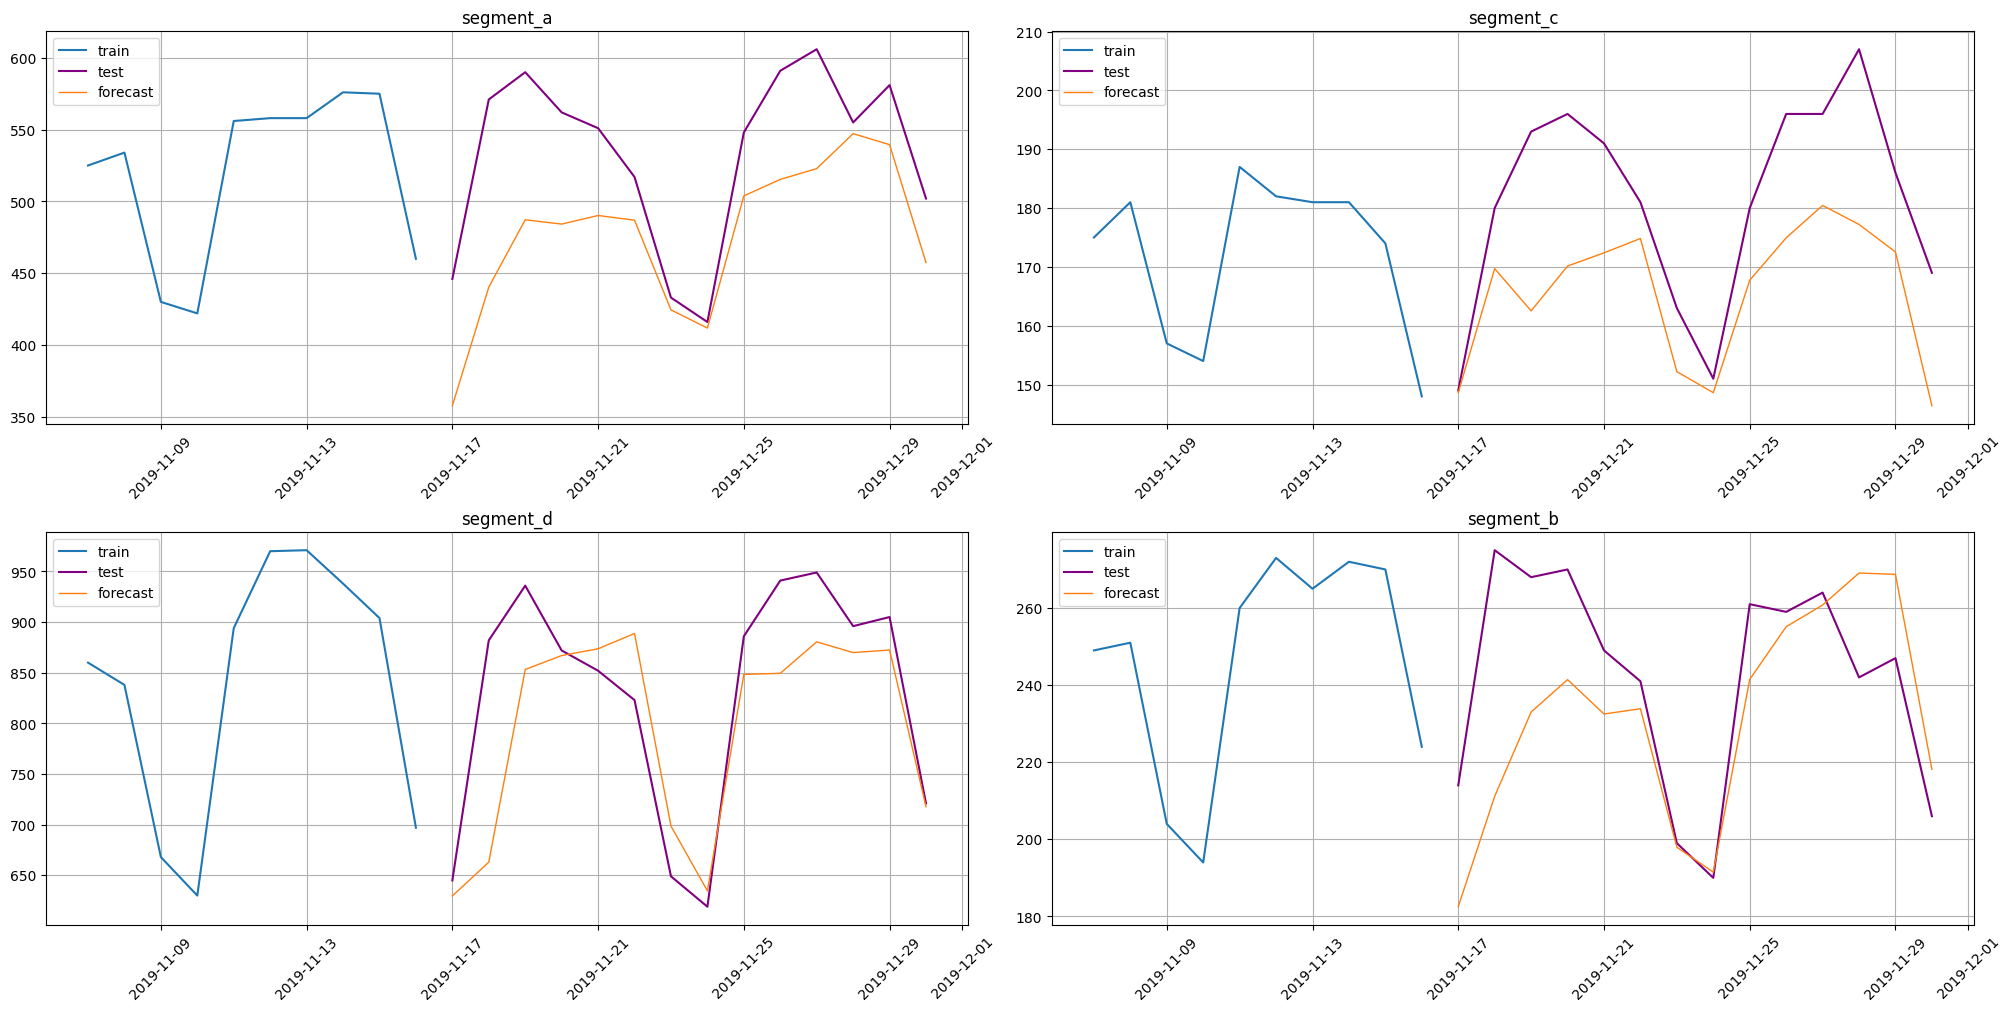

In [30]:
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

# Summary <a class="anchor" id="chapter3"></a>

As we can see, pipelines do a lot of work under the hood. 

Training:

- Applying transformations
- Fitting the model

Forecasting:

- Generating future dataset with applied transformations
- Forecasting with the fitted model
- Inverse transformation